## GAN with fashion-MNIST

- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout
import tensorflow as tf
from tensorflow import keras

In [3]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


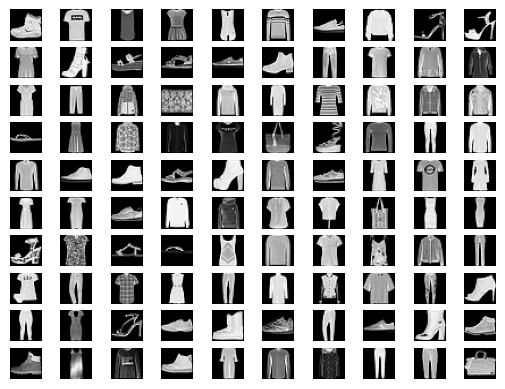

In [5]:
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i], cmap='gray')  # cmap = gray or gray_r
plt.show()

## 신경망 모델 구조의 시각화
1. summary()
2. pydot, graphviz 이용
- https://blog.naver.com/dic1224/221239472060

In [6]:
!pip install pydot

In [7]:
!pip install graphviz

In [8]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

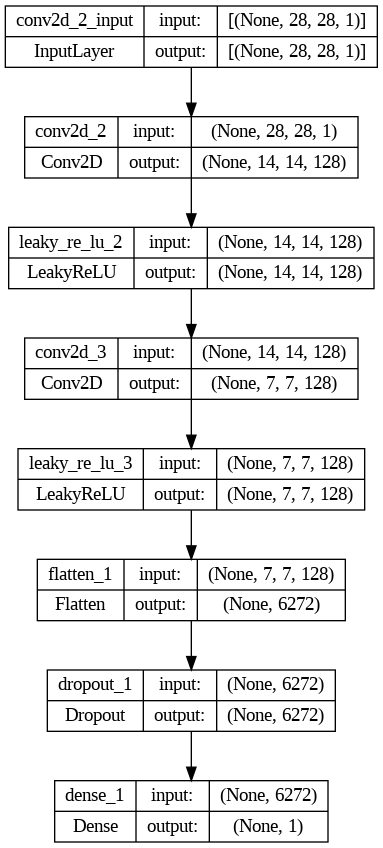

In [9]:
define_discriminator().summary()
keras.utils.plot_model(define_discriminator(), "gan_encoder.png", show_shapes=True)

- not compiled yet (intentionally), and returns the model

In [10]:
# take as input a point in the latent space & outputs a single 28x28 grayscale image
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 14x14
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 28x28
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))        # generate
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

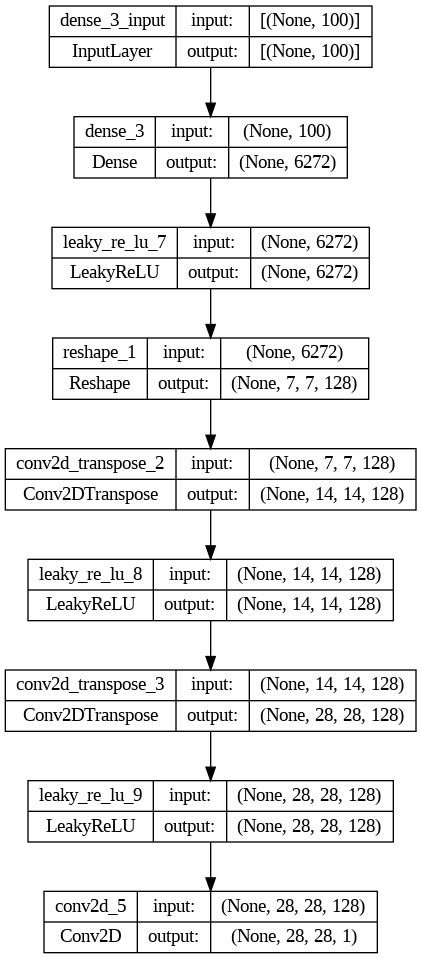

In [11]:
define_generator(100).summary()
keras.utils.plot_model(define_generator(100), "gan_encoder.png", show_shapes=True)

In [12]:
# define the combined generator and discriminator model, for updating the generator
# D 모델의 출력이 1이 되도록 generator만 학습

def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_5 (Sequential)   (None, 1)                 155137    
                                                                 
Total params: 1,319,426
Trainable params: 1,164,289
Non-trainable params: 155,137
_________________________________________________________________


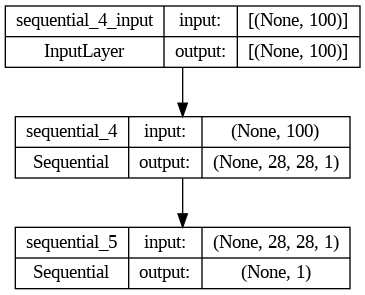

In [13]:
all = define_gan(define_generator(100), define_discriminator())
all.summary()
keras.utils.plot_model(all, "all.png", show_shapes=True)

### 차원 추가
- np.expand_dims(trainX, axis=-1) : 맨 뒤에 추가
  - https://rfriend.tistory.com/428
  - https://beelinekim.tistory.com/39

- discriminator 모델의 입력 데이터를 generator 모델의 출력값(tanh)과 맞춰 주기 위해서(-1~1)로 변환

In [14]:
# load fashion mnist images
def load_real_samples():
    (trainX, _), (_, _) = fashion_mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)   # expand to 3d, e.g. add channels (60000,28,28,1)
    X = X.astype('float32')               # convert from ints to floats
    X = (X - 127.5) / 127.5               # scale from [0,255] to [-1,1]
    return X

- We will require one batch (or a half) batch of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

In [15]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = np.ones((n_samples, 1))   # y_real = 1
    return X, y

- Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables.

In [16]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

- Next, we need to use the points in the latent space as input to the generator in order to generate new images.

In [17]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n_samples, 1))  # y_fake = 0
    return X, y

- We are now ready to fit the GAN models.
- Model 클래스 API(train_on_batch())
  - (참조) https://keras.io/ko/models/model/

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):   # n_epochs=100
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            # D 모델의 출력이 1이 되도록 generator만 학습
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # loss for the discriminator on real and fake, and loss for the generator
            print('>epoch:%d, batch:%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    g_model.save('generator.h5')

In [19]:
latent_dim = 100

discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2/2 [==============================] - 0s 5ms/step
>epoch:5, batch:309/468, d1=0.708, d2=0.630 g=0.816
2/2 [==============================] - 0s 7ms/step
>epoch:5, batch:310/468, d1=0.688, d2=0.676 g=0.773
2/2 [==============================] - 0s 6ms/step
>epoch:5, batch:311/468, d1=0.684, d2=0.737 g=0.707
2/2 [==============================] - 0s 4ms/step
>epoch:5, batch:312/468, d1=0.727, d2=0.746 g=0.715
2/2 [==============================] - 0s 4ms/step
>epoch:5, batch:313/468, d1=0.712, d2=0.714 g=0.742
2/2 [==============================] - 0s 5ms/step
>epoch:5, batch:314/468, d1=0.692, d2=0.669 g=0.800
2/2 [==============================] - 0s 9ms/step
>epoch:5, batch:315/468, d1=0.701, d2=0.636 g=0.822
2/2 [==============================] - 0s 5ms/step
>epoch:5, batch:316/468, d1=0.668, d2=0.634 g=0.860
2/2 [==============================] - 0s 16ms/step
>epoch:5, batch:317/468, d1=0.642, d2=0.635 g=0.810
2/2 [==============================]

>epoch:10, batch:468/468, d1=0.697, d2=0.685 g=0.728


- Now, we generate 100 random items of clothing

In [20]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    plt.figure(figsize=(12,12))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)    # define subplot
        plt.axis('off')             # turn off axis
        plt.imshow(examples[i, :, :, 0], cmap='gray')
    plt.show()

In [21]:
# load model
model = keras.models.load_model('generator.h5')

In [22]:
# generate images
latent_points = generate_latent_points(100, 100)

In [23]:
# generate images
X = model.predict(latent_points)

4/4 [==============================] - 0s 37ms/step


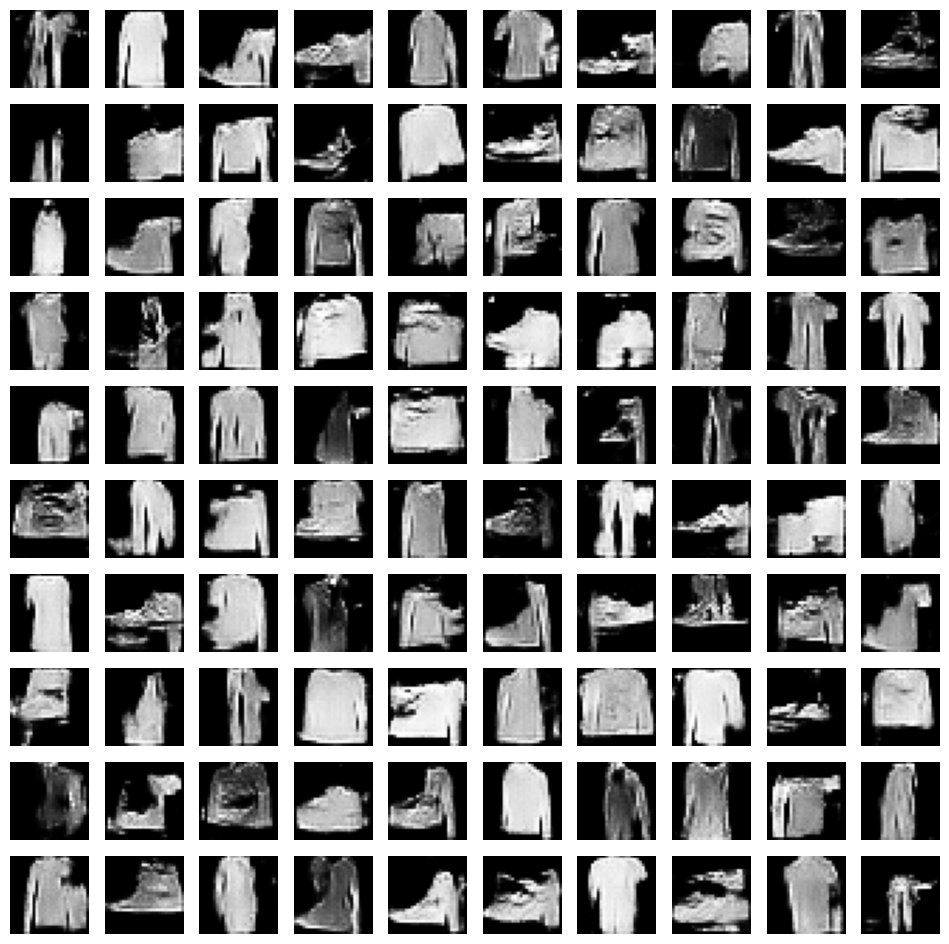

In [24]:
# plot the result
show_plot(X, 10)